<left>FINM 33150 - Quantitative Trading Strategies</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 5: FX Carry Strategy </center></h1>
<center>Due - 23:00 [CST] February 11th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

<h5> Imports </h5>

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import quandl

<h5> Constants </h5>

In [3]:
end_date = datetime.now().date().strftime('%Y-%m-%d')
quarterly_coupon = 0.25
weekly_interval = 1/52
float_years = 5
weekly_investment_USD = 10**7
leverage = 5

<h5> Helper Functions </h5>

In [4]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def grab_quandl_table(table_path,start_date = None,end_date = None):
    data = quandl.get(table_path, start_date=start_date, end_date=end_date, returns="pandas",
                      api_key='JbMPn9bSpFPNS7Z7PcZy')
    return data

In [5]:
def sort_tags(x):
    temp_l = x.split('-')
    if temp_l[1] == 'Year':
        return int(temp_l[0])
    elif temp_l[1] == 'Month':
        return int(temp_l[0])/12
    elif temp_l[1] == 'Week':
        return int(temp_l[0])/52
    else:
        raise Exception("Unknown Tenure")

In [6]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def compute_zcb_curve(spot_rates, coupon_frequency):
    zcb_curve = spot_rates.copy()
    tenors = zcb_curve.columns.map(sort_tags).values
    for tenor_tag in zcb_curve.columns:
        tenor = sort_tags(tenor_tag)
        spot_rates = zcb_curve[tenor_tag]
        coupon = spot_rates * coupon_frequency
        times = np.arange(tenor - coupon_frequency, 0, step = -coupon_frequency)[::-1]
        # Linear interpolation
        preceding_coupons_val = zcb_curve.apply(lambda x: np.exp(-np.interp(times, tenors, x.values)*times).sum(),
                                                axis = 1)
        preceding_coupons_val = preceding_coupons_val * coupon
        zcb_curve[tenor_tag] = -np.log((1 - preceding_coupons_val)/(1+coupon))/tenor
    return zcb_curve

In [7]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
def zcb_bond_price(zcb_curve, coupon_rates, tenure, coupon_frequency, offset = 0):
    df = zcb_curve.copy()
    times = np.arange(tenure, 0, step=-coupon_frequency)[::-1]
    times = times - offset # offset if time to maturity is not exactly the tenor of the bond
    tenures = df.columns.map(lambda x: int(x.split('-')[0])).values
    if times.shape[0]==0:
        prices = pd.DataFrame(index=zcb_curve.index, columns=['data']).fillna(1.0)
    else:
        # Linear interpolation
        coupons = df.apply(lambda x: np.exp(-np.interp(times, tenures, x.values)*times).sum(), axis = 1)
        r_T = df.apply(lambda x: np.interp(times[-1], tenures, x.values), axis = 1)
        prices = np.exp(-tenure*r_T) + coupon_frequency * coupon_rates * coupons
    return prices

In [8]:
def FX_Fixed_Carry(OIS, FX, cap, leverage, interval):
    df = FX.merge(OIS, how = 'inner', left_index = True, right_index = True).copy().dropna()
    df = df[df.index.map(lambda x: x.weekday()) == 2] # Wednesday-fy
    f, ir = df.columns
    # initial FX
    df[('Entry ' + f + ' FX')] = df[f]
    # terminal FX
    df[('Exit ' + f + ' FX')] = df[f].shift(-1)
    # initial IR
    df[('Fixed IR (' + f + ')')] = df[ir] + 50*10**(-4) #OIS + 50 b.p.
    # initial borrow (5x leverage)
    ret_series = -(cap*(1 - 1/leverage))*df[f]
    df[('Entry Borrow [' + f + ']')] = ret_series
    # 1-week interest in borrowed currency (OIS + 50 b.p.)
    ret_series = ret_series * np.exp(df[('Fixed IR (' + f + ')')]*interval/360)
    df[('Exit Borrow [' + f + ']')] = ret_series
    # back to funding-currency
    ret_series = ret_series / df[f].shift(-1) #convert back to USD
    df['Fixed 1-week Interest [USD]'] =  ret_series + (cap*(1 - 1/leverage))
    # delegating exposures
    df['FX Carry Exposure (Fixed) [USD]'] = ret_series - ret_series * df[f].shift(-1) / df[f]
    return df.iloc[:, -7:]

In [9]:
def FX_Float_Carry(YC, FX, cap, tenure, coupon_frequency, interval):
    df = FX.merge(YC, how = 'inner', left_index = True, right_index = True).copy().dropna()
    df = df[df.index.map(lambda x: x.weekday()) == 2] # Wednesday-fy
    f = df.columns[0] #column name
    tenure_tag = str(tenure) + '-Year'
    # computing zcb curve
    zcb_df = compute_zcb_curve(df.iloc[:, 1:], coupon_frequency)
    # computing entry and exit bond prices
    entry_bond = zcb_bond_price(zcb_df, df[tenure_tag], tenure, coupon_frequency)
    exit_bond = zcb_bond_price(zcb_df, df[tenure_tag], tenure, coupon_frequency, offset = interval)
    # initial FX
    df[('Entry ' + f + ' FX')] = df[f]
    # terminal FX
    df[('Exit ' + f + ' FX')] = df[f].shift(-1)
    # initial IR
    df[('Entry IR (' + f + ')')] = df[tenure_tag]
    # terminal IR
    df[('Exit IR (' + f + ')')] = df[tenure_tag].shift(-1)
    # simulating trade
    ret_series = cap * df[f] # exchange to home currency
    df[('Entry Lend [' + f + ']')] = ret_series
    ret_series = ret_series / entry_bond # buy long-term bonds
    ret_series = ret_series * exit_bond.shift(-1) # sell long-term bonds
    df[('Exit Lend [' + f + ']')] = ret_series
    ret_series = ret_series/df[f].shift(-1) # convert back to USD
    df['Float 1-week Interest [USD]'] = ret_series - cap
    # delegating exposures
    expected =  cap * exit_bond/entry_bond
    df['FX Carry Exposure (Float) [USD]'] = ret_series - ret_series * df[f].shift(-1) / df[f]
    df['IR Carry Exposure [USD]'] = ret_series * df[f].shift(-1) / df[f] - expected
    # reorganizing columns
    cols = df.columns.tolist()[-9:]
    return df[cols]

In [10]:
def FX_Fixed_Float_Carry(OIS, FX_fixed, YC, FX_float, cap, tenure, coupon_frequency, leverage, interval):
    # computing FX Fixed Carry
    fixed_df = FX_Fixed_Carry(OIS, FX_fixed, cap, leverage, interval)
    # computing FX Float Carry
    float_df = FX_Float_Carry(YC, FX_float, cap, tenure, coupon_frequency, interval)
    # merging data
    df = fixed_df.merge(float_df, how = 'inner', left_index = True, right_index = True)
    # setting entry date as columns
    df.reset_index(inplace = True)
    df.rename(columns={'index':'Entry Date'}, inplace = True)
    # creating exit date
    df['Exit Date'] = df['Entry Date'].shift(-1)
    # reorganizing columns
    cols = df.columns.tolist()
    cols = cols[:1] + cols[-1:] + cols[1:-1]
    df = df[cols]
    # identifying entry points (OIS + 50 b.p. < 5Y swap rate)
    df = df[df.iloc[:,4] < df.iloc[:,11]]
    # breakdown of P&L
    ## FX Exposure
    df['Net FX Carry Exposure [USD]'] = df['FX Carry Exposure (Fixed) [USD]'] + df['FX Carry Exposure (Float) [USD]']
    ## IR Exposure
    df['Net IR Carry Exposure [USD]'] = df['IR Carry Exposure [USD]']
    ## Net Exposure
    df['Net Carry Exposure [USD]'] = df['Net FX Carry Exposure [USD]'] + df['Net IR Carry Exposure [USD]']
    # P&L assessment
    investment = cap / leverage
    df['Weekly P&L [USD]'] = df['Fixed 1-week Interest [USD]'] + df['Float 1-week Interest [USD]']
    expected = df['Weekly P&L [USD]'] - df['Net Carry Exposure [USD]']
    df['Annualized Expected Return'] = np.log(expected/investment + 1) / interval
    df['Annualized Actual Return'] = np.log(df['Weekly P&L [USD]']/investment + 1) / interval
    df['Annualized Carry Delta'] = df['Annualized Actual Return'] - df['Annualized Expected Return']
    # double checking interval
    df = df[df['Entry Date'] + timedelta(timedelta(days=365*interval).days) == df['Exit Date']]
    return df.dropna()

In [11]:
def trades_summary(df_Carry):
    rows = df_Carry.shape[0]
    print('>>> There were', rows, 'Trades Simulated')
    Total_exp = df_Carry['Annualized Actual Return'].mean() * 100
    Total_vol = df_Carry['Annualized Actual Return'].std() * 100
    print('>>> The annualized mean return of the trades was', round(Total_exp, 4), '%')
    print('    with volatility of', round(Total_vol, 4), '%')
    Exp_exp = df_Carry['Annualized Expected Return'].mean() * 100
    Exp_vol = df_Carry['Annualized Expected Return'].std() * 100
    print('>>> The expected annualized mean return from the Fixed-Float was', round(Exp_exp, 4), '%')
    print('    with volatility of', round(Exp_vol, 4), '%')
    FX_fixed_exp = df_Carry['FX Carry Exposure (Fixed) [USD]'].mean().round(2)
    FX_fixed_vol = df_Carry['FX Carry Exposure (Fixed) [USD]'].std().round(4)
    print('>>> The average FX Carry Exposure from the Fixed IR trades was', FX_fixed_exp, 'USD')
    print('    with volatility of', FX_fixed_vol, 'USD')
    FX_float_exp = df_Carry['FX Carry Exposure (Float) [USD]'].mean().round(2)
    FX_float_vol = df_Carry['FX Carry Exposure (Float) [USD]'].std().round(4)
    print('>>> The average FX Carry Exposure from the Float IR trades was', FX_float_exp, "USD")
    print('    with volatility of', FX_float_vol, 'USD')
    IR_exp = df_Carry['IR Carry Exposure [USD]'].mean().round(2)
    IR_vol = df_Carry['IR Carry Exposure [USD]'].std().round(4)
    print('>>> The average IR Carry Exposure from the Float IR trades was', IR_exp, "USD")
    print('    with volatility of', IR_vol, 'USD')
    Net_exp = df_Carry['Net Carry Exposure [USD]'].mean().round(2)
    Net_vol = df_Carry['Net Carry Exposure [USD]'].std().round(4)
    print('>>> The average Net Carry Exposure was', Net_exp, "USD")
    print('    with volatility of', Net_vol, 'USD')
    Net_positive = df_Carry[df_Carry['Net Carry Exposure [USD]'] >= 0].shape[0]
    print('>>> There were a total of', Net_positive, 'trades with positive net Carry risk exposures')
    print('    and', rows - Net_positive, 'trades with negative net Carry risk exposures')
    print('>>> ', round(Net_positive/rows*100, ndigits = 2), '% of the trades had positive exposure')
    Net_delta = df_Carry['Annualized Carry Delta'].mean() * 100
    Net_delta_vol = df_Carry['Annualized Carry Delta'].std() * 100
    print('>>> The annualized mean return of the Carry risk was', round(Net_delta, 4), '%')
    print('    with volatility of', round(Net_delta_vol, 4), '%')

<h2> 2. Data </h2>

In [12]:
UK_OIS_1 = grab_quandl_table('YC/GBR_ISSC')['0.08Y']
UK_OIS_2 = grab_quandl_table('YC/GBR_ISSS', end_date = end_date)['0.08Y']
UK_OIS = pd.concat([UK_OIS_1,UK_OIS_2])/100

The UK Overnight Index Swap (OIS) data was gathered from the YC dataset in quandl.
The OIS data was separated into two tables in quandl (ISSC and ISSS).
The two tables were joined to make one OIS dataset.

In [13]:
GBP_FX = grab_quandl_table('CUR/GBP', end_date = end_date).rename(columns={'RATE':"GBP"})

All the available data on British Pound FX rate was gathered from the quandl CUR dataset.

In [14]:
VNM_YC = grab_quandl_table('YC/VNM', end_date = end_date)/100
THA_YC = grab_quandl_table('YC/THA', end_date = end_date)/100
PAK_YC = grab_quandl_table('YC/PAK', end_date = end_date)/100
PHL_YC = grab_quandl_table('YC/PHL', end_date = end_date)/100

The yield curve data for Vietnamese, Thai, Pakistani and Philippine bonds
were collected from the quandl YC dataset.

In [15]:
VND_FX = grab_quandl_table('CUR/VND', end_date = end_date).rename(columns={'RATE':"VND"})
THB_FX = grab_quandl_table('CUR/THB', end_date = end_date).rename(columns={'RATE':"THB"})
PKR_FX = grab_quandl_table('CUR/PKR', end_date = end_date).rename(columns={'RATE':"PKR"})
PHP_FX = grab_quandl_table('CUR/PHP', end_date = end_date).rename(columns={'RATE':"PHP"})

All the available data on Vietnamese Dong, Thai Baht, Pakistani Rupee and
Philippine Peso were collected from the quandl CUR dataset.

<h2> 3. Fixed-Float Carry </h2>

In [16]:
GBP_VND = FX_Fixed_Float_Carry(UK_OIS, GBP_FX, VNM_YC, VND_FX,
                               cap = weekly_investment_USD, interval = weekly_interval, leverage = leverage,
                               tenure = float_years, coupon_frequency = quarterly_coupon)

In [17]:
GBP_THB = FX_Fixed_Float_Carry(UK_OIS, GBP_FX, THA_YC, THB_FX,
                               cap = weekly_investment_USD, interval = weekly_interval, leverage = leverage,
                               tenure = float_years, coupon_frequency = quarterly_coupon)

In [18]:
GBP_PKR = FX_Fixed_Float_Carry(UK_OIS, GBP_FX, PAK_YC, PKR_FX,
                               cap = weekly_investment_USD, interval = weekly_interval, leverage = leverage,
                               tenure = float_years, coupon_frequency = quarterly_coupon)

In [19]:
GBP_PHP = FX_Fixed_Float_Carry(UK_OIS, GBP_FX, PHL_YC, PHP_FX,
                               cap = weekly_investment_USD, interval = weekly_interval, leverage = leverage,
                               tenure = float_years, coupon_frequency = quarterly_coupon)

The Fixed-Float Carry trade was simulated for all possible Wednesday to Wednesday weeks
from the data. As per the instruction, the notional amount for each trade was set as 10,000,000 USD.

The Fixed-Float Carry trade was constructed by simultaneously borrowing short-term rates in British Pounds
and holding long-term bonds in one of the four currencies for a week.

The leverage for the borrow was set as 5x, meaning a combination of 2,000,000 USD own capital and
8,000,000 USD borrowed capital were used for the purchase of long-term bonds. The 8,000,000 USD was
borrowed in British Pounds and was repaid after a week with interest at a fixed rate set as OIS + 50 b.p.
and the new exchange rate.

The float trade was simulated by buying and selling 5-Year bonds in the foreign market. At entrance,
10,000,000 USD worth foreign 5-Year bonds with quarterly coupons were purchased in home currency.
A week later, the bonds were sold at the new price with a definite change in maturity ($- \frac{1}{52}$)
and a possible change in interest rate. The price of the 5-Year bond was calculated by assuming the YC dataset
as swap curves. The swap curves would give the spot rate of the bonds which enable the calculation of
the zero-coupon bond rate and, ultimately, the bond price. The interest from this long-term lend was calculated
back to USD using the new exchange rate.

After each participated week, the profit/loss was calculated in United States Dollar terms.
The return of the trades and the carry risk were calculated against the invested own capital
2,000,000 USD.

The trades were only assumed to have entered when the float rate (spot rate from the 5-Year swap curve) was
higher than the fixed rate (OIS + 50 b.p.) and were assumed to have participated in every such week
included in the dataset.

<h2> 4. Analysis </h2>

For each week ($t_i$), the interest payment (in USD) from the fixed rate short-term borrow can be seen as:
$$ - 8,000,000 \times \frac{FX^{GBP}_{t_{i+1}}}{FX^{GBP}_{t_i}} \times (OIS_{t_i} + 50 \cdot 10^{-4}) $$

The interest gathered (in USD) from the float rate long-term lend in foreign bond ($A$) can be seen as:
$$ 10,000,000 \times \frac{FX^{A}_{t_{i+1}}}{FX^{A}_{t_i}} \times
\frac{P^{A, \left(5 - \frac{1}{52} \right)\text{-Year}}_{t_{i+1}}}{P^{A, \text{5-Year}}_{t_i}}$$

As shown above, this Fixed-Float Carry trade structure involves 3 different types of Carry risk.

First is from the FX rate change of GBP. The exchange rate change will affect the interest payment
needed on the 8,000,000 USD borrow and, thus, affect the weekly performance.

Second is from the interest rate change of the 5-Year foreign bond. We would expect an increase in price
since the maturity is decreased by $\frac{1}{52}$. However, if there is an additional change in
the spot rate of the 5-Year bond a week later, it would additionally affect the price of the bond and, thus,
our profit/loss on the trade. Though we expect the weekly changes in 5-Year foreign bonds to be low,
it would still be our carry risk in the trade.

The third is from the FX rate change in the home currency of the foreign 5-Year bond. In addition to the
risk of the change in interest rate, the exchange rate also plays a role in the performance of the trade
since the 5-Year bonds are sold in home currencies and exchanged back to US dollars at a new rate.

Since trades are only entered at weeks, where the rate of the lend is greater than the borrow, we expect
the return to be positive without the carried risk. If the carried risk plays in our favor, the trades will
be more profitable and visa-versa.

With the simulated trades, we will analyze how each of and combined carry risk behaves for the 4 currencies.

<h3> 4-1. USD-GBP Fixed, USD-VND Float Carry Trade </h3>

In [20]:
GBP_VND.head(10)

,Entry Date,Exit Date,Entry GBP FX,Exit GBP FX,Fixed IR (GBP),Entry Borrow [GBP],Exit Borrow [GBP],Fixed 1-week Interest [USD],FX Carry Exposure (Fixed) [USD],Entry VND FX,...,Float 1-week Interest [USD],FX Carry Exposure (Float) [USD],IR Carry Exposure [USD],Net FX Carry Exposure [USD],Net IR Carry Exposure [USD],Net Carry Exposure [USD],Weekly P&L [USD],Annualized Expected Return,Annualized Actual Return,Annualized Carry Delta
0,2014-12-03,2014-12-10,0.637756,0.636345,0.009275,-5102048.0,-5.102051e+06,-17742.777480,-17738.813996,21365.166667,...,13581.765278,7295.898752,8.773988,-10442.915245,8.773988,-10434.141256,-4161.012202,0.162846,-0.108299,-0.271145
1,2014-12-10,2014-12-17,0.636345,0.642142,0.009262,-5090760.0,-5.090763e+06,72216.863763,72220.821788,21349.600000,...,-9376.568957,-15567.258534,-11.298613,56653.563254,-11.298613,56642.264641,62840.294807,0.160900,1.608705,1.447805
3,2015-01-07,2015-01-14,0.661818,0.656415,0.009328,-5294544.0,-5.294547e+06,-65852.605741,-65848.619453,21423.083333,...,49736.148253,42508.987608,55.120376,-23339.631844,55.120376,-23284.511468,-16116.457487,0.186036,-0.420725,-0.606762
4,2015-01-14,2015-01-21,0.656415,0.660404,0.009322,-5251320.0,-5.251323e+06,48317.976466,48321.960333,21332.466667,...,-11663.631201,-18689.872716,-265.218327,29632.087617,-265.218327,29366.869290,36654.345266,0.189130,0.944385,0.755255
5,2015-01-21,2015-01-28,0.660404,0.660470,0.009330,-5283232.0,-5.283235e+06,795.444043,799.431107,21372.383333,...,21523.018196,14989.188344,-304.583186,15788.619451,-304.583186,15484.036265,22318.462239,0.177392,0.577066,0.399674
6,2015-01-28,2015-02-04,0.660470,0.658823,0.009345,-5283760.0,-5.283763e+06,-20003.305167,-19999.311768,21340.416667,...,8774.473665,3095.436821,-561.642564,-16903.874947,-561.642564,-17465.517511,-11228.831502,0.161902,-0.292772,-0.454674
7,2015-02-04,2015-02-11,0.658823,0.656171,0.009402,-5270584.0,-5.270587e+06,-32337.069191,-32333.051377,21333.816667,...,13388.270127,8346.909081,-267.821342,-23986.142296,-267.821342,-24253.963637,-18948.799064,0.137752,-0.495017,-0.632769
8,2015-02-11,2015-02-18,0.656171,0.647596,0.009420,-5249368.0,-5.249371e+06,-105934.319472,-105930.293764,21316.033333,...,-15035.288104,-19751.924546,-159.017720,-125682.218310,-159.017720,-125841.236030,-120969.607576,0.126508,-3.244347,-3.370855
9,2015-02-18,2015-02-25,0.647596,0.643971,0.009477,-5180768.0,-5.180771e+06,-45037.156539,-45033.106586,21358.200000,...,8227.179807,3530.040363,88.866339,-41503.066222,88.866339,-41414.199883,-36809.976732,0.119572,-0.965976,-1.085549
10,2015-02-25,2015-03-04,0.643971,0.655049,0.009498,-5151768.0,-5.151771e+06,135289.705268,135293.764230,21350.666667,...,-3349.874107,-7889.381500,-229.630485,127404.382730,-229.630485,127174.752245,131939.831161,0.123745,3.322025,3.198281


In [21]:
trades_summary(GBP_VND)

>>> There were 353 Trades Simulated
>>> The annualized mean return of the trades was 6.3918 %
    with volatility of 252.0643 %
>>> The expected annualized mean return from the Fixed-Float was 8.3662 %
    with volatility of 4.7294 %
>>> The average FX Carry Exposure from the Fixed IR trades was 2872.25 USD
    with volatility of 95638.2007 USD
>>> The average FX Carry Exposure from the Float IR trades was -1271.63 USD
    with volatility of 40351.7157 USD
>>> The average IR Carry Exposure from the Float IR trades was -16.61 USD
    with volatility of 273.8176 USD
>>> The average Net Carry Exposure was 1584.01 USD
    with volatility of 97183.461 USD
>>> There were a total of 180 trades with positive net Carry risk exposures
    and 173 trades with negative net Carry risk exposures
>>>  50.99 % of the trades had positive exposure
>>> The annualized mean return of the Carry risk was -1.9744 %
    with volatility of 252.1754 %


The Carry risk did not play in our favor and resulted in an average return lower than expected.
As expected, the exposure from 5-Year bond interest rate changes were low but negative.
The exposure from the GBP FX rate was positive but extremely volatile.
The exposure from the VND FX rate was negative but less volatile than the GBP

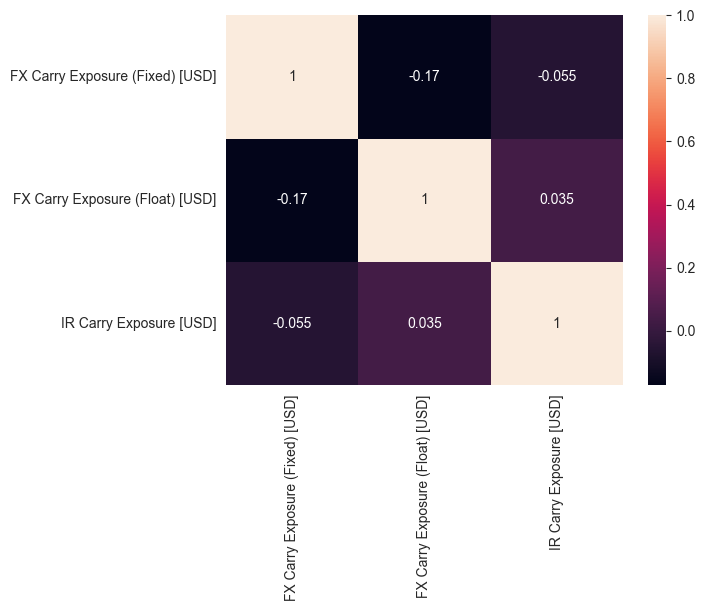

In [22]:
exposures1 = GBP_VND[['FX Carry Exposure (Fixed) [USD]',
                     'FX Carry Exposure (Float) [USD]',
                     'IR Carry Exposure [USD]']]/(10**7)
exposures1['FX Carry Exposure (Fixed) [USD]'] = exposures1['FX Carry Exposure (Fixed) [USD]']*5/4
sns.heatmap(exposures1.corr(), annot = True)
None

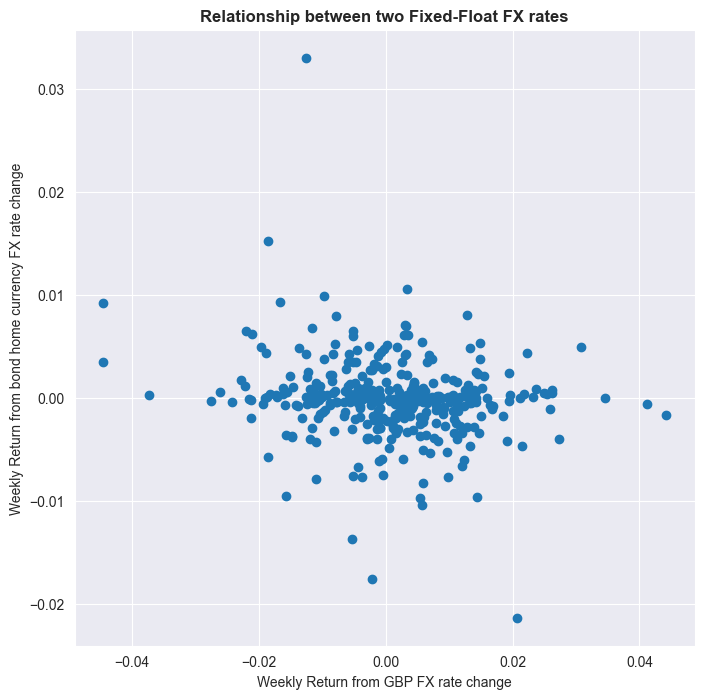

In [23]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures1['FX Carry Exposure (Fixed) [USD]'], exposures1['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from GBP FX rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between two Fixed-Float FX rates', fontsize=12, fontweight = "bold")
None

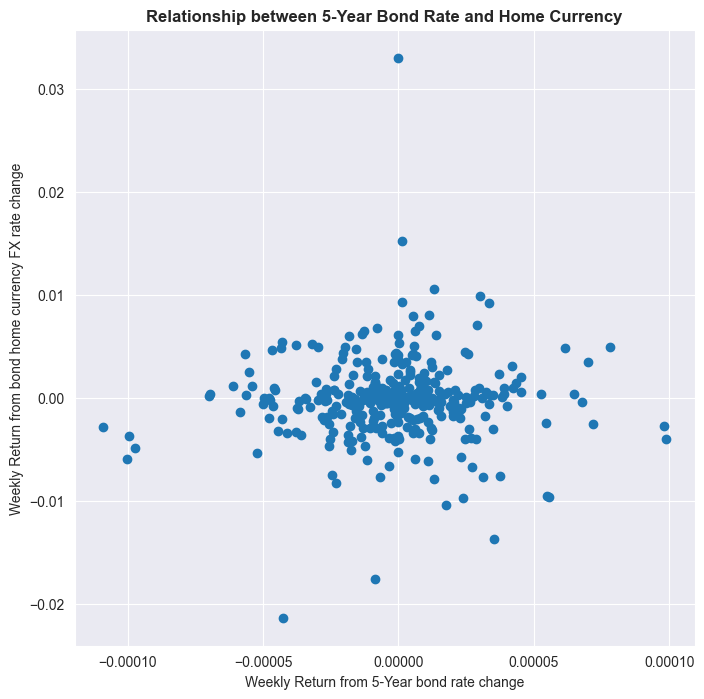

In [24]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures1['IR Carry Exposure [USD]'], exposures1['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from 5-Year bond rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between 5-Year Bond Rate and Home Currency', fontsize=12, fontweight = "bold")
None

The three carry risks show very low correlation and no apparent relationship.
Therefore, it would be hard to form an algorithm that ensures the carry risk plays in our favor.
Given that the mean return from the carry risk is negative, this carry trade appears to be inefficient.

<h3> 4-2. USD-GBP Fixed, USD-THB Float Carry Trade </h3>

In [25]:
GBP_THB.head(10)

,Entry Date,Exit Date,Entry GBP FX,Exit GBP FX,Fixed IR (GBP),Entry Borrow [GBP],Exit Borrow [GBP],Fixed 1-week Interest [USD],FX Carry Exposure (Fixed) [USD],Entry THB FX,...,Float 1-week Interest [USD],FX Carry Exposure (Float) [USD],IR Carry Exposure [USD],Net FX Carry Exposure [USD],Net IR Carry Exposure [USD],Net Carry Exposure [USD],Weekly P&L [USD],Annualized Expected Return,Annualized Actual Return,Annualized Carry Delta
0,2014-12-03,2014-12-10,0.637756,0.636345,0.009275,-5102048.0,-5.102051e+06,-17742.777480,-17738.813996,32.85658,...,24496.979278,8228.509587,15887.616745,-9510.304409,15887.616745,6377.312336,6754.201798,0.009798,0.175313,0.165515
1,2014-12-10,2014-12-17,0.636345,0.642142,0.009262,-5090760.0,-5.090763e+06,72216.863763,72220.821788,32.82961,...,-1480.286045,-37890.058323,36054.890723,34330.763465,36054.890723,70385.654188,70736.577718,0.009123,1.807374,1.798251
3,2015-01-07,2015-01-14,0.661818,0.656415,0.009328,-5294544.0,-5.294547e+06,-65852.605741,-65848.619453,32.87127,...,18605.998046,25446.337022,-7171.201728,-40402.282430,-7171.201728,-47573.484158,-47246.607695,0.008498,-1.243154,-1.251652
4,2015-01-14,2015-01-21,0.656415,0.660404,0.009322,-5251320.0,-5.251323e+06,48317.976466,48321.960333,32.78778,...,122572.977755,59507.717249,62715.825297,107829.677582,62715.825297,170545.502879,170890.954221,0.008981,4.263505,4.254524
5,2015-01-21,2015-01-28,0.660404,0.660470,0.009330,-5283232.0,-5.283235e+06,795.444043,799.431107,32.59503,...,-29081.995865,8898.718754,-38349.923328,9698.149861,-38349.923328,-28651.773467,-28286.551822,0.009495,-0.740701,-0.750196
6,2015-01-28,2015-02-04,0.660470,0.658823,0.009345,-5283760.0,-5.283763e+06,-20003.305167,-19999.311768,32.56594,...,3124.597863,-16187.607860,18955.191846,-36186.919628,18955.191846,-17231.727783,-16878.707305,0.009178,-0.440709,-0.449886
7,2015-02-04,2015-02-11,0.658823,0.656171,0.009402,-5270584.0,-5.270587e+06,-32337.069191,-32333.051377,32.61864,...,5624.477985,-9656.351662,14914.132215,-41989.403039,14914.132215,-27075.270824,-26712.591206,0.009429,-0.699207,-0.708636
8,2015-02-11,2015-02-18,0.656171,0.647596,0.009420,-5249368.0,-5.249371e+06,-105934.319472,-105930.293764,32.65012,...,96177.606310,24839.907085,70935.436069,-81090.386679,70935.436069,-10154.950611,-9756.713161,0.010353,-0.254295,-0.264648
9,2015-02-18,2015-02-25,0.647596,0.643971,0.009477,-5180768.0,-5.180771e+06,-45037.156539,-45033.106586,32.56979,...,7777.002990,15074.753008,-7694.538768,-29958.353578,-7694.538768,-37652.892346,-37260.153549,0.010210,-0.977902,-0.988112
10,2015-02-25,2015-03-04,0.643971,0.655049,0.009498,-5151768.0,-5.151771e+06,135289.705268,135293.764230,32.52073,...,12142.513205,45213.722124,-33465.737803,180507.486354,-33465.737803,147041.748551,147432.218473,0.010151,3.698533,3.688382


In [26]:
trades_summary(GBP_THB)

>>> There were 172 Trades Simulated
>>> The annualized mean return of the trades was 14.6766 %
    with volatility of 249.3815 %
>>> The expected annualized mean return from the Fixed-Float was 1.146 %
    with volatility of 0.4704 %
>>> The average FX Carry Exposure from the Fixed IR trades was 4052.26 USD
    with volatility of 97737.9191 USD
>>> The average FX Carry Exposure from the Float IR trades was -136.79 USD
    with volatility of 66836.1554 USD
>>> The average IR Carry Exposure from the Float IR trades was 3584.19 USD
    with volatility of 28093.0884 USD
>>> The average Net Carry Exposure was 7499.66 USD
    with volatility of 95921.7369 USD
>>> There were a total of 89 trades with positive net Carry risk exposures
    and 83 trades with negative net Carry risk exposures
>>>  51.74 % of the trades had positive exposure
>>> The annualized mean return of the Carry risk was 13.5306 %
    with volatility of 249.3665 %


The Carry risk did play in our favor and resulted in an average return more than 13% higher than expected.
As expected, the exposure from 5-Year bond interest rate changes were low but negative.
The exposure from the GBP FX rate was positive but extremely volatile.
The exposure from the THB FX rate was also positive but less volatile than the GBP.

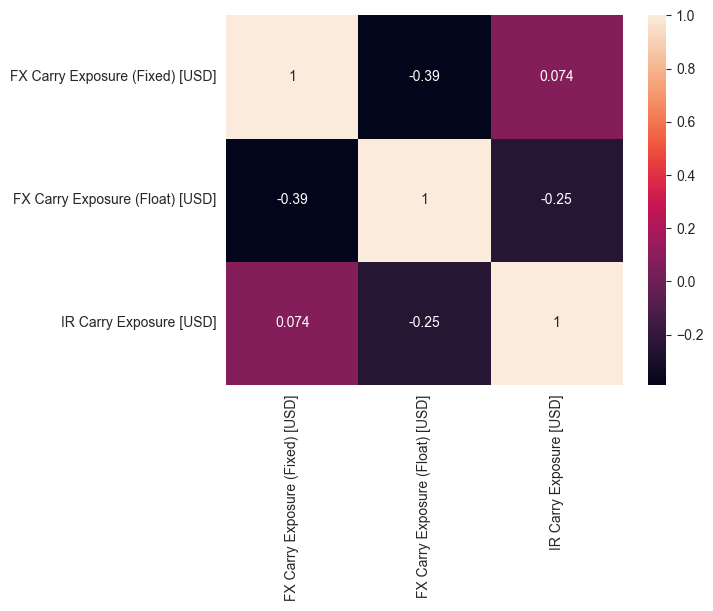

In [27]:
exposures2 = GBP_THB[['FX Carry Exposure (Fixed) [USD]',
                     'FX Carry Exposure (Float) [USD]',
                     'IR Carry Exposure [USD]']]/(10**7)
exposures2['FX Carry Exposure (Fixed) [USD]'] = exposures2['FX Carry Exposure (Fixed) [USD]']*5/4
sns.heatmap(exposures2.corr(), annot = True)
None

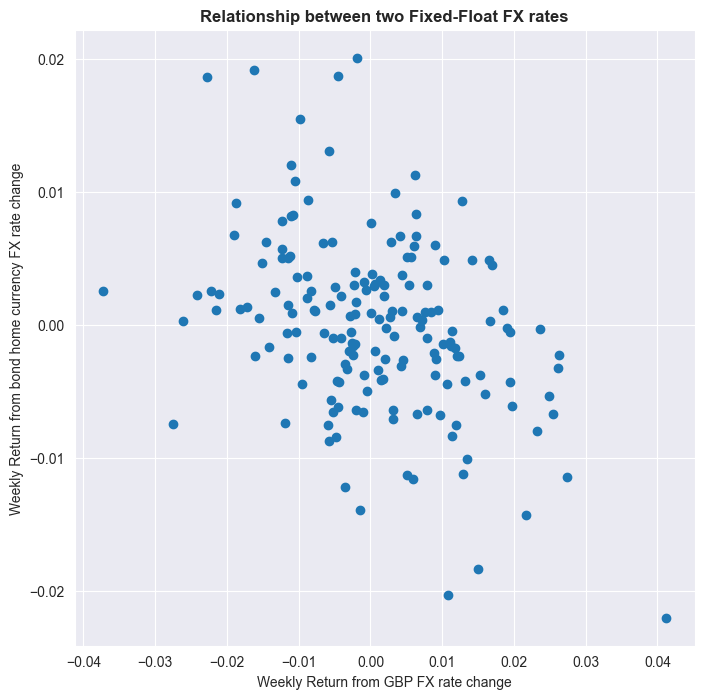

In [28]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures2['FX Carry Exposure (Fixed) [USD]'], exposures2['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from GBP FX rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between two Fixed-Float FX rates', fontsize=12, fontweight = "bold")
None

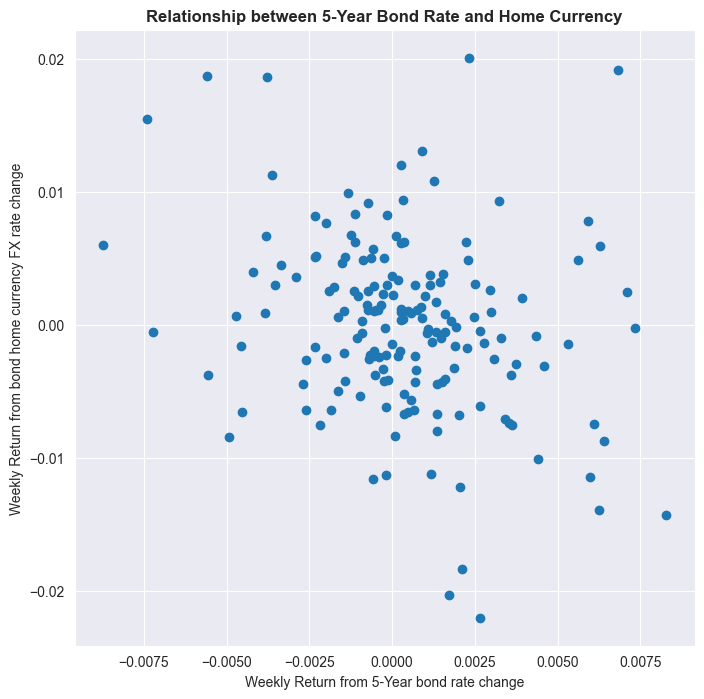

In [29]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures2['IR Carry Exposure [USD]'], exposures2['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from 5-Year bond rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between 5-Year Bond Rate and Home Currency', fontsize=12, fontweight = "bold")
None

Compared to the USD-VND Fixed-Float Carry trade, the Fixed-Float Carry trade with Thai Baht showed stronger
correlation between the USD-GBP and USD-THB FX rate changes. The correlation is negative as shown in the heat-map
and the scatter plot. This would negatively affect the Carry trade since the two currencies move in opposite directions.
However, the correlation between the USD-THB FX rate and the foreign 5-Year bond rate is also relatively stronger and
negative. Therefore, the losses from a decrease in USD-THB FX rate would have been partially covered by the increase
in interest rate.
From this relationship, though still not stable, USD-THB FX Fixed-Float Carry trade seems to be a more profitable
strategy.

<h3> 4-3. USD-GBP Fixed, USD-PKR Float Carry Trade </h3>

In [30]:
GBP_PKR.head(10)

,Entry Date,Exit Date,Entry GBP FX,Exit GBP FX,Fixed IR (GBP),Entry Borrow [GBP],Exit Borrow [GBP],Fixed 1-week Interest [USD],FX Carry Exposure (Fixed) [USD],Entry PKR FX,...,Float 1-week Interest [USD],FX Carry Exposure (Float) [USD],IR Carry Exposure [USD],Net FX Carry Exposure [USD],Net IR Carry Exposure [USD],Net Carry Exposure [USD],Weekly P&L [USD],Annualized Expected Return,Annualized Actual Return,Annualized Carry Delta
0,2014-08-13,2014-08-20,0.594915,0.601742,0.009245,-4759320.0,-4.759322e+06,90759.244907,90763.195810,99.006720,...,-119701.649193,-128449.131728,1.862645e-09,-37685.935919,1.862645e-09,-37685.935919,-28942.404286,0.226836,-0.758000,-0.984837
1,2014-08-20,2014-08-27,0.601742,0.604459,0.009244,-4813936.0,-4.813938e+06,35955.495623,35959.445939,100.293860,...,-141653.874826,-146885.571546,-3.515786e+03,-110926.125607,-3.515786e+03,-114441.911421,-105698.379203,0.226836,-2.823441,-3.050278
2,2014-08-27,2014-09-03,0.604459,0.607120,0.009239,-4835672.0,-4.835674e+06,35059.977221,35063.925594,101.788200,...,-39637.513549,-37830.280300,-1.055106e+04,-2766.354706,-1.055106e+04,-13317.414581,-4577.536328,0.226742,-0.119152,-0.345894
3,2014-09-03,2014-09-10,0.607120,0.620875,0.009278,-4856960.0,-4.856962e+06,177229.865378,177233.830547,102.174800,...,59209.286055,29352.077003,2.112437e+04,206585.907550,2.112437e+04,227710.273116,236439.151433,0.226457,5.810363,5.583906
4,2014-09-10,2014-09-17,0.620875,0.615145,0.009269,-4967000.0,-4.967002e+06,-74523.013682,-74519.052738,101.876661,...,-72722.411522,-78163.697547,-3.313501e+03,-152682.750285,-3.313501e+03,-155996.250919,-147245.425204,0.227025,-3.976632,-4.203657
5,2014-09-17,2014-09-24,0.615145,0.610145,0.009326,-4921160.0,-4.921162e+06,-65562.205140,-65558.219649,102.678800,...,4709.656216,-12627.829420,8.635064e+03,-78186.049068,8.635064e+03,-69550.985266,-60852.548924,0.225669,-1.606736,-1.832405
6,2014-09-24,2014-10-01,0.610145,0.616736,0.009308,-4881160.0,-4.881162e+06,85491.317036,85495.294937,102.808400,...,8203.732095,24031.355155,-2.457571e+04,109526.650092,-2.457571e+04,84950.942971,93695.049131,0.226851,2.380731,2.153880
8,2014-10-15,2014-10-22,0.629226,0.620700,0.009325,-5033808.0,-5.033811e+06,-109892.874991,-109888.889925,102.881861,...,-10786.132447,-19519.588370,0.000000e+00,-129408.478296,0.000000e+00,-129408.478296,-120679.007438,0.226472,-3.236305,-3.462778
9,2014-10-22,2014-10-29,0.620700,0.624410,0.009325,-4965600.0,-4.965602e+06,47528.909471,47532.894709,103.082899,...,-412176.255385,-21872.607671,-3.990371e+05,25660.287038,-3.990371e+05,-373376.816599,-364647.345913,0.226472,-10.467013,-10.693485
10,2014-10-29,2014-11-05,0.624410,0.626335,0.009324,-4995280.0,-4.995282e+06,24583.508748,24587.493387,103.318061,...,-83117.157225,55106.345615,-1.465238e+05,79693.839001,-1.465238e+05,-66829.964155,-58533.648476,0.215258,-1.544589,-1.759847


In [31]:
trades_summary(GBP_PKR)

>>> There were 238 Trades Simulated
>>> The annualized mean return of the trades was -49.9424 %
    with volatility of 456.5697 %
>>> The expected annualized mean return from the Fixed-Float was 14.9091 %
    with volatility of 7.7046 %
>>> The average FX Carry Exposure from the Fixed IR trades was 7839.03 USD
    with volatility of 107343.034 USD
>>> The average FX Carry Exposure from the Float IR trades was -19783.0 USD
    with volatility of 88820.0303 USD
>>> The average IR Carry Exposure from the Float IR trades was -5684.63 USD
    with volatility of 87966.3564 USD
>>> The average Net Carry Exposure was -17628.6 USD
    with volatility of 163011.0661 USD
>>> There were a total of 116 trades with positive net Carry risk exposures
    and 122 trades with negative net Carry risk exposures
>>>  48.74 % of the trades had positive exposure
>>> The annualized mean return of the Carry risk was -64.8516 %
    with volatility of 457.4048 %


The Carry risk did not play in our favor and resulted in an average return much lower than expected.
Unlike expected, the exposure from 5-Year bond interest rate changes were unexpectedly high and very volatile.
The exposure from the GBP FX rate was positive but extremely volatile.
The exposure from the PKR FX rate was very negative but less volatile than the GBP

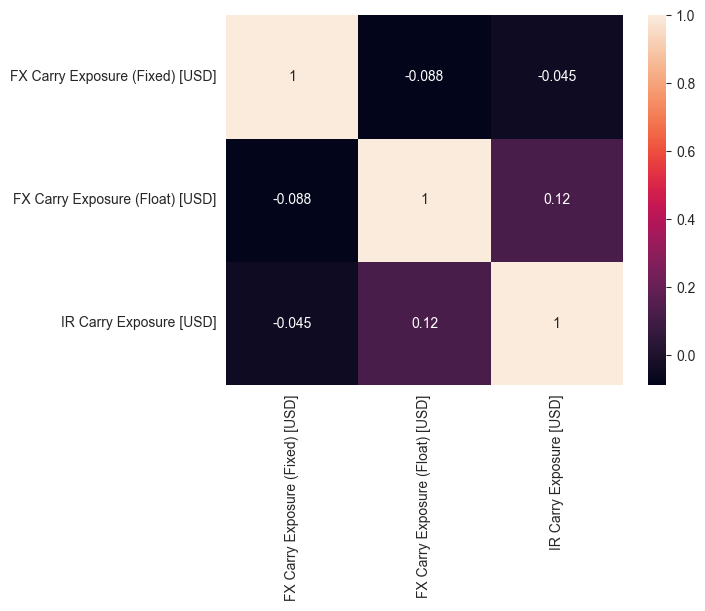

In [32]:
exposures3 = GBP_PKR[['FX Carry Exposure (Fixed) [USD]',
                     'FX Carry Exposure (Float) [USD]',
                     'IR Carry Exposure [USD]']]/(10**7)
exposures3['FX Carry Exposure (Fixed) [USD]'] = exposures3['FX Carry Exposure (Fixed) [USD]']*5/4
sns.heatmap(exposures3.corr(), annot = True)
None

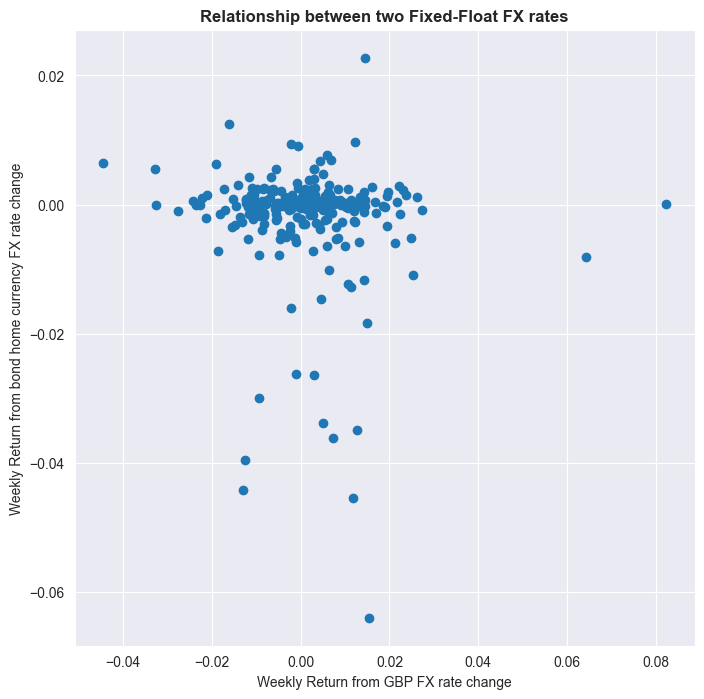

In [33]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures3['FX Carry Exposure (Fixed) [USD]'], exposures3['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from GBP FX rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between two Fixed-Float FX rates', fontsize=12, fontweight = "bold")
None

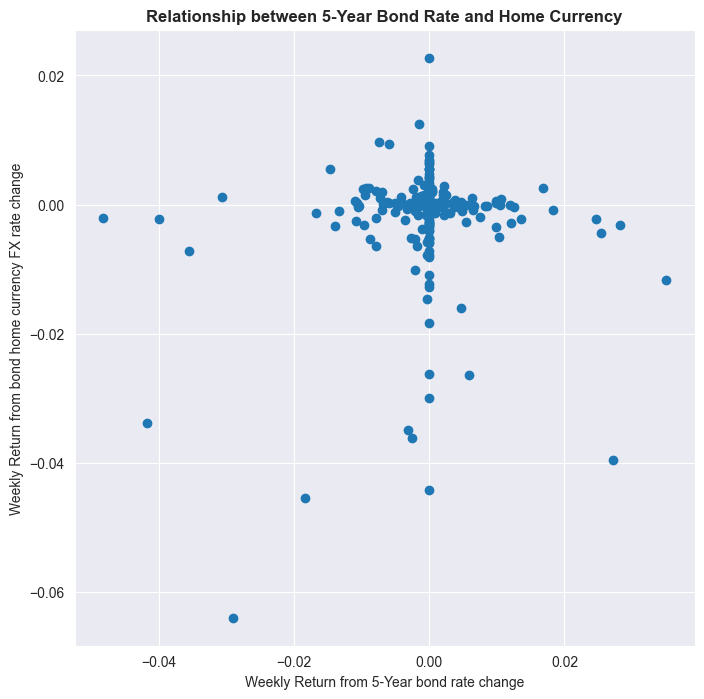

In [34]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures3['IR Carry Exposure [USD]'], exposures3['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from 5-Year bond rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between 5-Year Bond Rate and Home Currency', fontsize=12, fontweight = "bold")
None

The GBP-PKR carry trade seems to suffer from huge drops in USD-PKR FX rate. As shown in the scatter plots, there seems
to be much more variation in weekly return caused by USD-PKR FX rate change. The majority of these returns seem to be
negative, and it is negatively skewed.
Though the heat-map shows some relatively stronger correlations between the interest rate change and the FX rate
change for the PKR, judging from the scatter plots, it is hard to determine a reliable relationship between the three
 carry risks.
From the simulated trade, the benefits of this Fixed-Float FX Carry may only root from timing the USD-PKR FX rate
changes accurately. Overall, it seems like an inefficient and highly unprofitable trade.

<h3> 4-4. USD-GBP Fixed, USD-PHP Float Carry Trade </h3>

In [35]:
GBP_PHP.head(10)

,Entry Date,Exit Date,Entry GBP FX,Exit GBP FX,Fixed IR (GBP),Entry Borrow [GBP],Exit Borrow [GBP],Fixed 1-week Interest [USD],FX Carry Exposure (Fixed) [USD],Entry PHP FX,...,Float 1-week Interest [USD],FX Carry Exposure (Float) [USD],IR Carry Exposure [USD],Net FX Carry Exposure [USD],Net IR Carry Exposure [USD],Net Carry Exposure [USD],Weekly P&L [USD],Annualized Expected Return,Annualized Actual Return,Annualized Carry Delta
0,2014-12-03,2014-12-10,0.637756,0.636345,0.009275,-5102048.0,-5.102051e+06,-17742.777480,-17738.813996,44.69717,...,-61635.892424,23551.189623,-87022.461435,5812.375627,-87022.461435,-81210.085808,-79378.669904,0.047595,-2.105919,-2.153514
1,2014-12-10,2014-12-17,0.636345,0.642142,0.009262,-5090760.0,-5.090763e+06,72216.863763,72220.821788,44.59125,...,-185464.501355,-37866.009300,-148512.789857,34354.812488,-148512.789857,-114157.977369,-113247.637592,0.023663,-3.031088,-3.054752
3,2015-01-07,2015-01-14,0.661818,0.656415,0.009328,-5294544.0,-5.294547e+06,-65852.605741,-65848.619453,45.07233,...,62687.856424,87255.313735,-26503.369439,21406.694283,-26503.369439,-5096.675156,-3164.749316,0.050206,-0.082349,-0.132554
4,2015-01-14,2015-01-21,0.656415,0.660404,0.009322,-5251320.0,-5.251323e+06,48317.976466,48321.960333,44.68150,...,52275.247771,56394.790604,-5574.392209,104716.750937,-5574.392209,99142.358727,100593.224237,0.037709,2.551776,2.514067
5,2015-01-21,2015-01-28,0.660404,0.660470,0.009330,-5283232.0,-5.283235e+06,795.444043,799.431107,44.43083,...,-28674.906113,69310.972629,-99042.019661,70110.403735,-99042.019661,-28931.615926,-27879.462069,0.027349,-0.729966,-0.757314
6,2015-01-28,2015-02-04,0.660470,0.658823,0.009345,-5283760.0,-5.283763e+06,-20003.305167,-19999.311768,44.12199,...,309408.851434,5297.002666,302563.377516,-14702.309102,302563.377516,287861.068414,289405.546267,0.040141,7.027541,6.987400
7,2015-02-04,2015-02-11,0.658823,0.656171,0.009402,-5270584.0,-5.270587e+06,-32337.069191,-32333.051377,44.09932,...,-330584.783999,-70745.689944,-260877.241202,-103078.741321,-260877.241202,-363955.982523,-362921.853190,0.026880,-10.412176,-10.439056
8,2015-02-11,2015-02-18,0.656171,0.647596,0.009420,-5249368.0,-5.249371e+06,-105934.319472,-105930.293764,44.42197,...,292012.853925,57238.383970,233157.821841,-48691.909794,233157.821841,184465.912046,186078.534453,0.041911,4.626031,4.584120
9,2015-02-18,2015-02-25,0.647596,0.643971,0.009477,-5180768.0,-5.180771e+06,-45037.156539,-45033.106586,44.17492,...,-75448.738519,22740.574939,-99529.555497,-22292.531647,-99529.555497,-121822.087144,-120485.895058,0.034729,-3.230962,-3.265692
10,2015-02-25,2015-03-04,0.643971,0.655049,0.009498,-5151768.0,-5.151771e+06,135289.705268,135293.764230,44.07370,...,212554.135020,-11391.128071,223807.531061,123902.636159,223807.531061,347710.167219,347843.840288,0.003475,8.338211,8.334736


In [36]:
trades_summary(GBP_PHP)

>>> There were 249 Trades Simulated
>>> The annualized mean return of the trades was -2.8754 %
    with volatility of 537.2425 %
>>> The expected annualized mean return from the Fixed-Float was 3.8792 %
    with volatility of 2.4164 %
>>> The average FX Carry Exposure from the Fixed IR trades was 3174.28 USD
    with volatility of 112203.8917 USD
>>> The average FX Carry Exposure from the Float IR trades was -1890.15 USD
    with volatility of 67355.3354 USD
>>> The average IR Carry Exposure from the Float IR trades was 6765.54 USD
    with volatility of 164212.9588 USD
>>> The average Net Carry Exposure was 8049.67 USD
    with volatility of 211779.0427 USD
>>> There were a total of 125 trades with positive net Carry risk exposures
    and 124 trades with negative net Carry risk exposures
>>>  50.2 % of the trades had positive exposure
>>> The annualized mean return of the Carry risk was -6.7546 %
    with volatility of 537.2399 %


The Carry risk did not play in our favor and resulted in an average return lower than expected.
Unlike expected, the exposure from 5-Year bond interest rate changes were the highest and very volatile.
The exposure from the GBP FX rate was positive but extremely volatile.
The exposure from the PHP FX rate was negative but less volatile than the GBP.

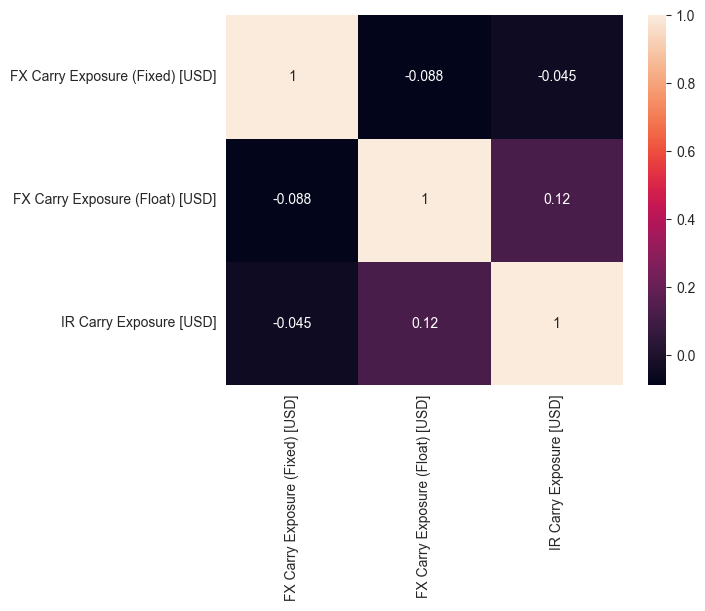

In [37]:
exposures4 = GBP_PHP[['FX Carry Exposure (Fixed) [USD]',
                     'FX Carry Exposure (Float) [USD]',
                     'IR Carry Exposure [USD]']]/(10**7)
exposures4['FX Carry Exposure (Fixed) [USD]'] = exposures4['FX Carry Exposure (Fixed) [USD]']*5/4
sns.heatmap(exposures3.corr(), annot = True)
None

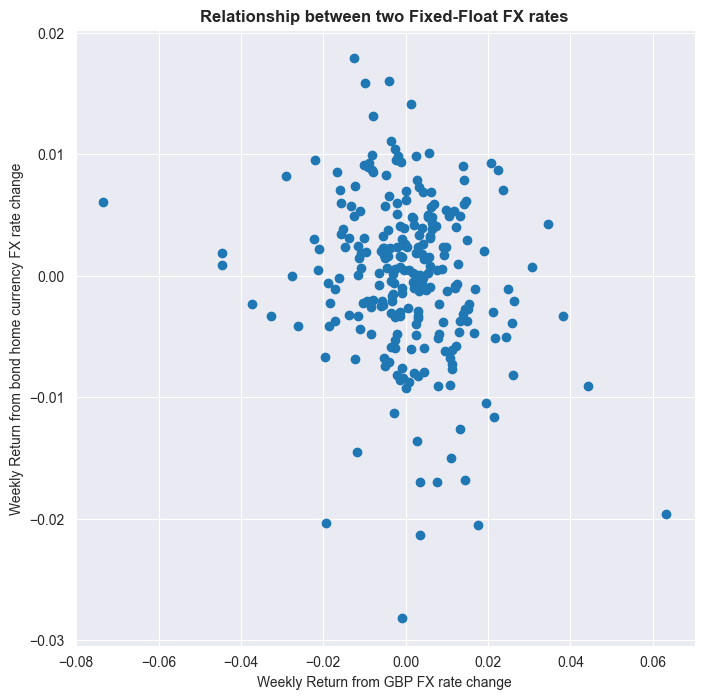

In [38]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures4['FX Carry Exposure (Fixed) [USD]'], exposures4['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from GBP FX rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between two Fixed-Float FX rates', fontsize=12, fontweight = "bold")
None

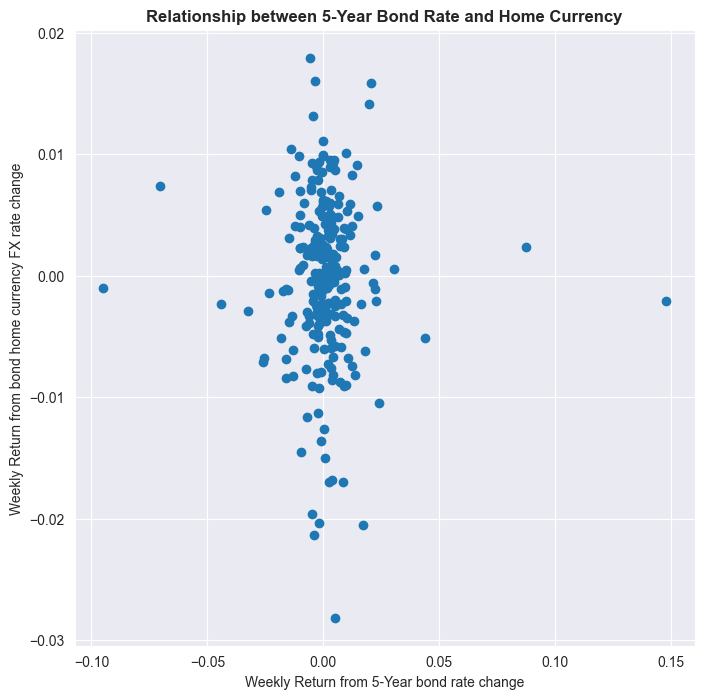

In [39]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(exposures4['IR Carry Exposure [USD]'], exposures4['FX Carry Exposure (Float) [USD]'])
# x axis labels
ax.set_xlabel('Weekly Return from 5-Year bond rate change', fontsize=10)
# y axis labels
ax.set_ylabel('Weekly Return from bond home currency FX rate change', fontsize=10)
# title
ax.set_title('Relationship between 5-Year Bond Rate and Home Currency', fontsize=12, fontweight = "bold")
None

The case of GBP-PHP Fixed Float FX Carry trade is very similar to that of the GBP-PKR trade.
However, given the low expected annualized return, it seems like there was not much Fixed-Float spread
investment opportunity to begin with. Though the percentage of mean returns is much lower in absolute
value than the GBP-PKR case, given that there was not much spread to invest in the first place, the
negative effect of the carried risk seems to be huge.
Similar to the PKR case, GBP-PHP seems to suffer loss from the volatile FX rate changes. However, unlike
the PKR case, these trades seem to show a relatively stronger negative correlation between the USD-GBP
rate changes and the USD-PHP rate changes. Using this relationship, we may be able to simulate a more
efficient and profitable carry trade algorithm.